In [11]:
from support_functions import *

In [12]:
import numpy as np
from qiskit_experiments.library import QuantumVolume

In [13]:
def all_keys(q):
    keys = []
    vector = [0 for _ in range(q)]
    while(vector[-1]<2):
        keystr = ''
        for b in vector:
            keystr += str(b)
        keys.append(keystr)
        
        vector[0] += 1
        for i in range(0,q-1):
            if( vector[i] >= 2):
                vector[i] = 0
                vector[i+1] += 1
            else:
                break
    return keys

#allkeys = all_keys(6)
#print(allkeys)

# Quantum volume

In [14]:
def Generate_QuantumVolumeCircuits(nr_qubits, nr_of_circuits):
    qv = QuantumVolume([i for i in range(nr_qubits)], trials=nr_of_circuits)
    circs = qv.circuits()
    return circs

In [15]:
q = 5
n_tests = 20

In [59]:
coef3 = 0.24
coef2 = 8.13
def size_pred(q, coef3, coef2):
    return coef3 * q**3 + coef2 * q**2

In [7]:
for q in range(4,17):
    circs = Generate_QuantumVolumeCircuits(q, n_tests)
    total_size = 0
    for circ in circs:
        tdc = transpile(circ.decompose(reps=2), basis_gates=load_noise_thermal().basis_gates, coupling_map=get_coupling_map(q), optimization_level=3)
        total_size += tdc.size()
    print(q, round(total_size / n_tests,1), round(size_pred(q),1), round(total_size / (n_tests*q),3))

4 135.2 11.2 33.8 2.8


5 201.7 15.0 40.33 3.0


6 375.7 19.2 62.617 3.2


7 458.6 23.8 65.521 3.4


8 682.0 28.8 85.256 3.6


9 813.9 34.2 90.433 3.8


10 1137.3 40.0 113.735 4.0


11 1278.6 46.2 116.236 4.2


12 1627.7 52.8 135.637 4.4


13 1804.8 59.8 138.835 4.6


14 2301.2 67.2 164.371 4.8


15 2514.0 75.0 167.6 5.0


16 3152.7 83.2 197.041 5.2


In [60]:
X = [q for q in range(4,17)]
Y = [135.2, 201.7, 375.7, 458.6, 682.0, 813.9, 1137.3, 1278.6, 1627.7, 1804.8, 2301.2, 2514.0, 3152.7]
best_diff = sum( (Y[i]-size_pred(4+i,coef3,coef2))**2 for i in range(len(Y)) )
for c2 in range(100):
    for c3 in range(100):
        tcoef2 = 8.19 + (c2-50)*0.01
        tcoef3 = 0.24 + (c3-50)*0.01
        diff = sum( (Y[i]-size_pred(4+i,tcoef3,tcoef2))**2 for i in range(len(Y)) )
        if( diff < best_diff ):
            best_diff = diff
            coef3 = tcoef3
            coef2 = tcoef2
print(coef3, coef2)

0.24 8.13


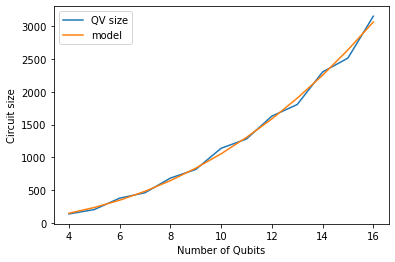

In [62]:
figure, ax = plt.subplots()
Y2 = [ size_pred(q, coef3, coef2) for q in X ]
plt.plot(X,Y)
plt.plot(X,Y2)
plt.legend(['QV size', 'model'])
ax.set_xlabel('Number of Qubits')
ax.set_ylabel('Circuit size')
#plt.savefig('QV_circuit_size.png')
plt.show()

# Quantum amplitude estimation

In [31]:
def MLE_MCI_f_uniform(nr_of_qubits,powers, f_lst):
    """
    Function that generates a circuit of nr_of_qubits qubits with powers amplification rounds 
    for the maximum likelihood estimator for monte carlo integration of the function f_lst 
    against the probability distribution prob_lst.
    """
    n = nr_of_qubits
    qc = QuantumCircuit(n,1)
    all_qubits = [i for i in range(n)]
    sample_qubits = [i for i in range(n-1)]
    
    #Prepare samping points / state
    qc.append(uniform_dist(n-1), sample_qubits)
    #qc.append(uni_prob_mat(prob_lst), sample_qubits)

    #qc.barrier()

    #Evaluate function
    qc.append(uni_integration_mat(f_lst),all_qubits)#f(x)=f(x)
    

    for _ in range(powers):
        #qc.barrier()    
        qc.z(n-1)
        #qc.barrier()
        #Invert function
        qc.append(inv_uni_integration_mat(f_lst),all_qubits)#f(x)=f(x)
        
        #qc.barrier()
        qc.x(n-1)
        qc.h(n-1)
        qc.append(inv_uniform_dist(n-1), sample_qubits)
        #qc.append(inv_uni_prob_mat(prob_lst), sample_qubits)
        for i in range(n-1):
            qc.x(i)
        qc.mcx(sample_qubits,n-1)
        qc.h(n-1)
        qc.x(n-1)
        for i in range(n-1):
            qc.x(i)
        qc.append(uniform_dist(n-1), sample_qubits)
        #qc.append(uni_prob_mat(prob_lst), sample_qubits)
        #qc.barrier()
        #Evaluate function
        qc.append(uni_integration_mat(f_lst),all_qubits)#f(x)=f(x)

    qc.measure(n-1,0)
    return qc

In [32]:
%%time
Results = []
n_tests = 1
for q in range(4,10):
    for R in range(0,1):
        total_size = 0
        total_size_uniform = 0
        for n in range(n_tests):
            prob_lst = [np.random.uniform(0.0,1.0) for _ in range(2**(q-1)) ]
            f_lst = [np.random.uniform(0.0,1.0) for _ in range(2**(q-1)) ]
            sum_p = sum(x for x in prob_lst)
            sum_f = sum(x for x in f_lst)
            prob_lst = [p/sum_p for p in prob_lst ]
            f_lst = [f/sum_f for f in f_lst ]

            circ = MLE_MCI_f(q,R,prob_lst,f_lst)
            tdc = transpile(circ.decompose(reps=2), basis_gates=load_noise_thermal().basis_gates, coupling_map=get_coupling_map(q), optimization_level=3)
            total_size += tdc.size()

            circ_uniform = MLE_MCI_f_uniform(q,R,f_lst)
            tdc_uniform = transpile(circ_uniform.decompose(reps=2), basis_gates=load_noise_thermal().basis_gates, coupling_map=get_coupling_map(q), optimization_level=3)
            total_size_uniform += tdc_uniform.size()
        Results.append([q, R, total_size / n_tests])
        print(q, R, round(total_size / n_tests,1), round(total_size / (n_tests*(2*R+1)),2), round(total_size_uniform / n_tests,1))


4 0 1216.0 1216.0 761.0


5 0 3476.0 3476.0 2036.0


6 0 10465.0 10465.0 6088.0


7 0 26324.0 26324.0 14340.0


8 0 80958.0 80958.0 48787.0


9 0 252378.0 252378.0 128878.0
CPU times: user 1h 12min 14s, sys: 44.8 s, total: 1h 12min 58s
Wall time: 1h 14min 48s


In [63]:
%%time
Results2 = []
n_tests = 1
for q in range(4,8):
    for R in range(0,3):
        total_size = 0
        total_size_uniform = 0
        for n in range(n_tests):
            prob_lst = [np.random.uniform(0.0,1.0) for _ in range(2**(q-1)) ]
            f_lst = [np.random.uniform(0.0,1.0) for _ in range(2**(q-1)) ]
            sum_p = sum(x for x in prob_lst)
            sum_f = sum(x for x in f_lst)
            prob_lst = [p/sum_p for p in prob_lst ]
            f_lst = [f/sum_f for f in f_lst ]

            circ = MLE_MCI_f(q,R,prob_lst,f_lst)
            tdc = transpile(circ.decompose(reps=2), basis_gates=load_noise_thermal().basis_gates, coupling_map=get_coupling_map(q), optimization_level=3)
            total_size += tdc.size()

            circ_uniform = MLE_MCI_f_uniform(q,R,f_lst)
            tdc_uniform = transpile(circ_uniform.decompose(reps=2), basis_gates=load_noise_thermal().basis_gates, coupling_map=get_coupling_map(q), optimization_level=3)
            total_size_uniform += tdc_uniform.size()
        Results2.append([q, R, total_size / n_tests])
        print(q, R, round(total_size / n_tests,1), round(total_size / (n_tests*(2*R+1)),2), round(total_size_uniform / n_tests,1))


4 0 1221.0 1221.0 768.0


4 1 3699.0 1233.0 2349.0


4 2 6163.0 1232.6 3947.0


5 0 3441.0 3441.0 2038.0


5 1 10674.0 3558.0 6417.0


5 2 17862.0 3572.4 10590.0


6 0 10609.0 10609.0 6072.0


6 1 35258.0 11752.67 18784.0


6 2 57122.0 11424.4 32010.0


7 0 26481.0 26481.0 14386.0


7 1 81142.0 27047.33 44156.0


7 2 135850.0 27170.0 74190.0
CPU times: user 52min 20s, sys: 20.3 s, total: 52min 40s
Wall time: 46min 14s


In [54]:
coef1 = 17.35
coef2 = 0.46

def QAE_size(q, R, coef1, coef2):
    return coef1 * (2*R+1) * 10**(coef2*q)

In [55]:
best_diff = sum( ( np.log(s) - np.log(QAE_size(q,R,coef1,coef2)) )**2 for [q,R,s] in Results )
for c1 in range(100):
    for c2 in range(100):
        cf1 = max( 17.35 + (c1-50) * 0.01, 0.01 )
        cf2 = 0.46 + (c2-50) * 0.001
        diff = sum( ( np.log(s) - np.log(QAE_size(q,R,cf1,cf2)) )**2 for [q,R,s] in Results )
        if( diff < best_diff ):
            best_diff = diff
            coef1 = cf1
            coef2 = cf2
print(coef1, coef2)

17.35 0.46


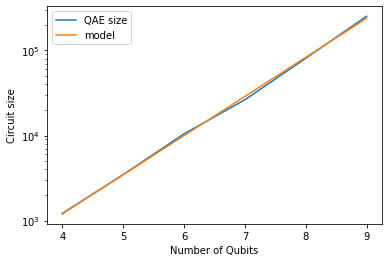

In [57]:
X = [q for [q,R,s] in Results]
Y = [s for [q,R,s] in Results]
Y3 = [ QAE_size(q,R,coef1, coef2) for [q,R,s] in Results ]
figure, ax = plt.subplots()
plt.plot(X,Y)
plt.plot(X,Y3)
plt.legend(['QAE size', 'model'])
ax.set_xlabel('Number of Qubits')
ax.set_ylabel('Circuit size')
ax.set_yscale('log')
#plt.savefig('QAE_circuit_size_log.png')
plt.show()